In [1]:
## Dependencies

# Image processing and plots
import cv2 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from PIL import Image

import os
import numpy as np
import torch

# Image Processing

## Reading, Padding, Normalizing and Calculating tx, ty, tw, th

In [37]:
"""
## To-Do next session
- Rethink normalization to after padding 
- Check out how did bob liu cal tx, ty (was bx, by normailized)?


## Image Processing
- Read the image and labels (images using mpimg)
    - Change from HWC to CHW
- Pad the image based on the input dim to the net
    + Resize the labels and test
- Normalize the image and the labels
    + Need to check about normalized labels (read coco and multiply tx..th with img dim)
    + Change the labels accordingly 
- Calculate the ground truth value for tx,ty,tw,th

## Clarifications (At the bottom of the notebook)
- The Coco dataset labels have been normalized w.r.t image dim, the real labels can be 
 retrived by multiplying x axis values (x, and w) with the width of image and similarly 
 for y axis.
- Reading images with mpimg seemed to have better results as opposed to cv2
 
"""

'\n## To-Do next session\n- Rethink normalization to after padding \n- Check out how did bob liu cal tx, ty (was bx, by normailized)?\n\n\n## Image Processing\n- Read the image and labels (images using mpimg)\n    - Change from HWC to CHW\n- Pad the image based on the input dim to the net\n    + Resize the labels and test\n- Normalize the image and the labels\n    + Need to check about normalized labels (read coco and multiply tx..th with img dim)\n    + Change the labels accordingly \n- Calculate the ground truth value for tx,ty,tw,th\n\n## Clarifications (At the bottom of the notebook)\n- The Coco dataset labels have been normalized w.r.t image dim, the real labels can be \n retrived by multiplying x axis values (x, and w) with the width of image and similarly \n for y axis.\n- Reading images with mpimg seemed to have better results as opposed to cv2\n \n'

In [2]:
## Helper functions

def read_image(image_path):
    """
    We read the image located at the path image_path

    Args:
        image_path (str): The path of the image
    
    Returns:
        np.ndarray: The image in numpy array
    """
    # We read the image
    try:
        image = plt.imread(image_path)
    except OSError as err:
        print("Error: " + str(err))
        return None

    # We take the maximum pixel value of each filter
    max = np.max(image, axis=0)
    max = np.max(max, axis=0, keepdims=True)
    max = np.tile(max, (image.shape[0], image.shape[1], 1))

    # We take the minimum pixel value of each filter
    min = np.min(image, axis=0)
    min = np.min(min, axis=0, keepdims=True)
    min = np.tile(min, (image.shape[0], image.shape[1], 1))

    # and we do a min-max normalization
    image = ((image - min) / (max-min))**(1/2.2)

    return image

In [163]:
## Reading images and labels

# List of image and label paths
path = '../Data/PNG_TREATED/'
img_list = sorted([os.path.join(os.path.realpath('.'), path ,img) 
            for img in os.listdir(path) if img.endswith(".PNG")])
label_list = sorted([os.path.join(os.path.realpath('.'), path, label)
             for label in os.listdir(path) if label.endswith(".txt")])

# Read normalized images lists 
temp_ls = list(np.random.choice(len(img_list),5))
img_read = [read_image(img_list[x]) for x in temp_ls]
label_list = [label_list[i] for i in temp_ls]
#img_read = [np.transpose(img_read[i],(2,0,1)) for i in range(len(img_read))]

In [164]:
label_list 

['/Users/allwynjoseph/Desktop/MLDM master/Semester 3/dl_project/Yolo/../Data/PNG_TREATED/Canon1DsMkIII_0009.txt',
 '/Users/allwynjoseph/Desktop/MLDM master/Semester 3/dl_project/Yolo/../Data/PNG_TREATED/Canon1DsMkIII_0005.txt',
 '/Users/allwynjoseph/Desktop/MLDM master/Semester 3/dl_project/Yolo/../Data/PNG_TREATED/Canon1DsMkIII_0011.txt',
 '/Users/allwynjoseph/Desktop/MLDM master/Semester 3/dl_project/Yolo/../Data/PNG_TREATED/Canon1DsMkIII_0007.txt',
 '/Users/allwynjoseph/Desktop/MLDM master/Semester 3/dl_project/Yolo/../Data/PNG_TREATED/Canon1DsMkIII_0013.txt']

In [166]:
temp_ls

[5, 1, 7, 3, 9]

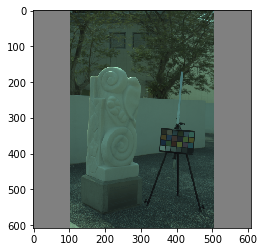

In [167]:
## Image padding and label resizing

dim = 608
new_img = np.full((dim, dim, 3), 128, dtype='float64')

# Pad the image
img_idx = 1

img_h, img_w, _ = img_read[img_idx].shape
new_w = int(img_w*min(dim/img_w, dim/img_h))
new_h = int(img_h*min(dim/img_w, dim/img_h))
temp_img = cv2.resize(img_read[img_idx], (new_w, new_h), interpolation = cv2.INTER_AREA) #cv.INTER_AREA cv2.INTER_CUBIC
new_img[(dim - new_h)//2: new_h + (dim - new_h)//2, (dim - new_w)//2: new_w + (dim - new_w)//2, :] = temp_img
#new_img = new_img.transpose((2,0,1))
#new_img = [np.transpose(new_img[i],(2,0,1)) for i in range(len(img_read))]
#cv2.resize(img_read[1], (new_w, new_h), interpolation = cv2.INTER_CUBIC)

#temp = new_img.transpose((2,0,1))
plt.imshow(new_img)
plt.show()

In [382]:
## Label reconstruction based on padding and resizing

# Read labels
label_path = label_list[idx]
f = open(label_path, "r")
mask = f.readlines()

# Converting string elements to float
for n,i in enumerate(mask):
    temp = [float(mask[n].split(' ')[j]) for j in range(5)]
    mask[n] = temp
    
h_adj = (dim - new_h)//2
w_adj = (dim - new_w)//2

# Accounting for image resizing and padding
for n, i in enumerate(mask):
    mask[n][1] = i[1]*new_w + w_adj
    mask[n][2] = i[2]*new_h + h_adj
    mask[n][3] = i[3]*new_w
    mask[n][4] = i[4]*new_h


In [402]:
plt.imsave()

(25, 5)

In [383]:
## Creating the real Y

def mid_points(b_x_y, c_x_y):
    
    t_x_y = -np.log((1- b_x_y + c_x_y)/(b_x_y - c_x_y))
    return t_x_y
    
    
def size_bb(b_w_h ,p_w_h):
    
    t_w_h = np.log(b_w_h/p_w_h)
    return t_w_h
    

def true_dectection(stride, input_dim, anchor, masks, labels):
    
    rows = int(((input_dim/stride)**2)*3)
    true_detection = np.zeros((rows, 30))
    
    for label in labels:
        
        p_x, b_x, b_y, b_w, b_h = label
        
        # Scaled coordinates (w.r.t stride
        c_x = int(b_x/stride)
        c_y = int(b_y/stride)
        t_x = mid_points(b_x/stride, c_x)
        t_y = mid_points(b_y/stride, c_y)
       
        
        area_target = b_w*b_h
        area_bb = [anchors[i-1][0]*anchors[i-1][1] for i in masks]
        area_diff = [abs(area_target - area_bb[i]) for i in range(len(area_bb))]
        bb_num = area_diff.index(min(area_diff))
        bb_idx = masks[bb_num] - 1
        p_w, p_h = anchor[bb_idx]
 
        t_w = size_bb(b_w/stride ,p_w/stride)
        t_h = size_bb(b_h/stride ,p_h/stride)
        
        grid_num = c_x * c_y
        row_num = grid_num + bb_num  # idx is 0,1,2
        true_detection[row_num,:5] = [t_x, t_y, t_w, t_h, 1]
        true_detection[row_num, int(5+p_x)] = 1
        print(row_num)
    
        print(b_x/stride, c_x, b_y/stride, c_y)
    print(p_w, p_h)
    print(grid_num, bb_num)
    print(t_x, t_y, t_w, t_h)
    print(row_num)
    print(p_x)
    
    return true_detection
    
    
"""
( x30)
              tx  ty  tw  th  p0  p1 .... p25
BB_1(0,0)
BB_2(0,0)
BB_3(0,0)
.
.
BB_3(18,18)
BB_1(0,0)
.
.
BB_3(37,37)
BB_1(0,0)
.
.
BB_3(75,75)

bx/y = sigma(tx/y) + cx/y
bw/h = pw/h*exp(tw/h)

"""
stride = 8
input_dim = 608
masks = [1,2,3]
anchors = [(10,13),(16,30),(33,23),(30,61),(62,45),(59,119),(116,90),  
           (156,198),(373,326)]
labels = mask
write = 0
if not write:
    y_target = true_dectection(stride, input_dim, anchors, masks, labels)
    write = 1
    
else:
    temp_detection = true_dectection(stride, input_dim, anchor, masks, labels)
    y_target.concatenate(temp_detection)




1418
59.44435813034891 59 24.82424217974181 24
1404
54.03672547728769 54 26.989566782522342 26
1485
55.957914417379854 55 27.19266757696127 27
1539
57.90459512837393 57 27.39876986097319 27
1593
59.87714285714284 59 27.60737338629593 27
1647
61.87620803159973 61 27.818728277060575 27
1764
63.90254114549045 63 28.033084657398213 28
1350
54.38920737327188 54 25.156357000993047 25
1400
56.315299539170496 56 25.347877048162857 25
1450
58.26683344305464 58 25.541848311817276 25
1500
60.244634628044764 60 25.738696002979147 25
1550
62.248953258722835 62 25.937794811320753 25
1664
64.28053982883475 64 26.13964498510427 26
1242
54.74263989466754 54 23.318469898212513 23
1288
56.673685319289 56 23.498109049155907 23
1334
58.63057274522711 58 23.680149391757695 23
1380
60.61337722185647 60 23.864615938430983 23
1488
62.622699144173794 62 24.051558714001985 24
1536
64.65978933508886 64 24.24102774329692 24
1155
55.09699802501645 55 21.475555300397218 21
1197
57.032896642527966 57 21.6432885427010

In [397]:
100%100

0

In [351]:
b_x = np.array([16.2599473,7.8,8.9])
c_x = np.array([16,7,8])

-np.log((1- b_x + c_x)/(b_x - c_x))

array([-1.04624248,  1.38629436,  2.19722458])

In [296]:
b_w = 6.78
p_w = 6
np.log(b_w/p_w)

0.1222176327242493

In [318]:
masks = [7,8,9]
anchors = [(10,13),(16,30),(33,23),(30,61),(62,45),(59,119),(116,90),  
           (156,198),(373,326)]
[anchors[i-1][0]*anchors[i-1][1] for i in masks]
for i in masks:
    print(anchors[i-1])

(116, 90)
(156, 198)
(373, 326)


In [327]:
area_target = 25000
area_bb = [anchors[i-1][0]*anchors[i-1][1] for i in masks]

area_diff = [abs(area_target - area_bb[i]) for i in range(len(area_bb))]
p_w, p_h = anchors[masks[area_diff.index(min(area_diff))]]

In [341]:
int(((input_dim/stride)**2)*3)

1083

In [332]:
a[2,:4] = [1,2,3,4]

In [346]:
mask[0]

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  2.,  3.,  4., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

# Clarifications

## Normalization of COCO dataset labels

In [ ]:
## Reading images

# List of image and label paths
path = 'Data/COCO_sample/'
img_list = [os.path.join(os.path.realpath('.'), path +'images',img) for img in os.listdir(path +'images')]
label_list = [os.path.join(os.path.realpath('.'), path +'labels',label) for label in os.listdir(path + 'labels')]

# Read images and label data into lists
img_read = [cv2.imread(x) for x in img_list]


In [ ]:
print(img_read[4].shape)
plt.imshow(img_read[4])
plt.show()

In [79]:
# Reading labels 
f  = open(label_list[4], 'rb') 
f.read()

b'16 0.606688 0.341381 0.544156 0.510000 \n'

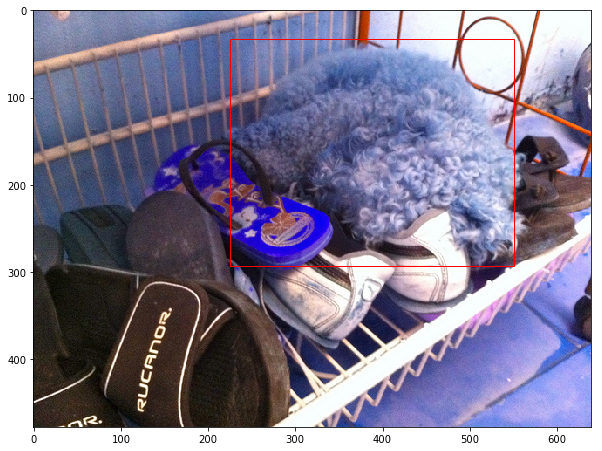

In [78]:
fig,ax = plt.subplots(1)
fig.set_size_inches(10,10)
# Display the image
ax.imshow(img_read[4])

# Add the patch to the Axes
rect_1 = patches.Rectangle((388.28- 326/2, 163.18 - 260/2),326, 260,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect_1)
plt.show()

## Reading images with open CV and Matplot.lib

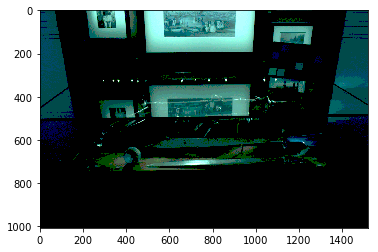

In [153]:
## OpenCV

f  = open('train.txt', 'rb') 
path = f.read().decode('ascii').strip().split()[2]

temp = cv2.imread(path)
temp = temp/np.max(temp) # Normalize image
temp = temp ** (1/2.2) 
plt.imshow(temp)
plt.show()

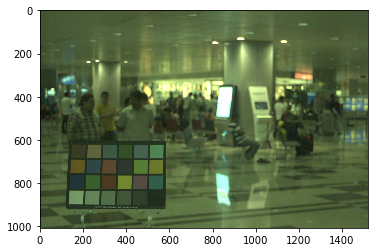

In [23]:
## mpimg

## Extract path
f  = open('train.txt', 'rb') 
path = f.read().decode('ascii').strip().split()[40]

## Image plot
image = read_image(path)
#image = image ** (1/5) 
plt.imshow(image)
plt.show()

## Test on Normalized and Padded images

### Normalized images

In [82]:
idx = 9
norm_image = img_read[idx]
h, w, _ = norm_image.shape

f =open(label_list[idx], "r")
mask = f.readlines()
for n,i in enumerate(mask):
    temp = [float(mask[n].split(' ')[j]) for j in range(5)]
    mask[n] = temp
    
# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(10,10)
# Display the image
ax.imshow(norm_image)

for n,i in enumerate(mask):
    
    temp_pt = patches.Rectangle(((i[1] - i[3]/2)*w, (i[2] - i[4]/2)*h), i[3]*w, i[4]*h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(temp_pt)
       
    
plt.show()

ValueError: could not convert string to float: '1143,1514.6,499.99,371.87\n'

### Padded images

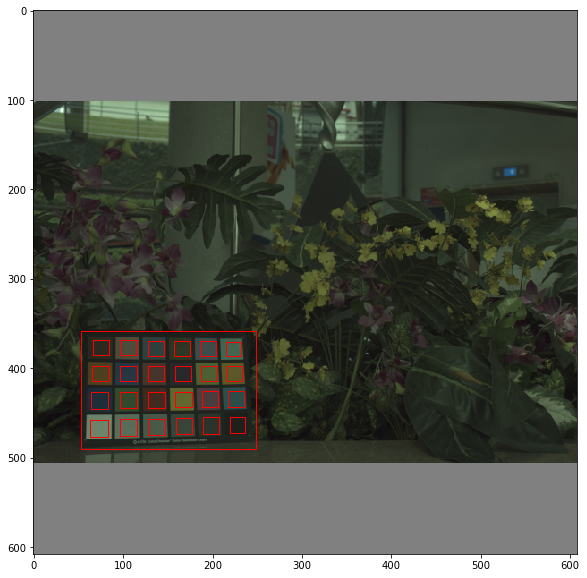

In [172]:
idx = 0
dim = 608


# Resize and pad image
new_img = np.full((dim, dim, 3), 128, dtype='float64')
img_h, img_w, _ = img_read[idx].shape
new_w = int(img_w*min(dim/img_w, dim/img_h))
new_h = int(img_h*min(dim/img_w, dim/img_h))
temp_img = cv2.resize(img_read[idx], (new_w, new_h), interpolation = cv2.INTER_AREA) #cv.INTER_AREA cv2.INTER_CUBIC
new_img[(dim - new_h)//2: new_h + (dim - new_h)//2, (dim - new_w)//2: new_w + (dim - new_w)//2, :] = temp_img

# Read labels
f =open(label_list[idx], "r")

mask = f.readlines()

# Convert str to float
for n,i in enumerate(mask):
    temp = [float(mask[n].split(' ')[j]) for j in range(5)]
    mask[n] = temp


h_adj = (dim - new_h)//2
w_adj = (dim - new_w)//2

# modify the labels w.r.t resize and pad
for n, i in enumerate(mask):
    mask[n][1] = i[1]*new_w + w_adj
    mask[n][2] = i[2]*new_h + h_adj
    mask[n][3] = i[3]*new_w
    mask[n][4] = i[4]*new_h

# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(10,10)

# Display the image
ax.imshow(new_img)


for n,i in enumerate(mask):
    
    temp_pt = patches.Rectangle((i[1]- i[3]/2, i[2] - i[4]/2), 
                                i[3], i[4], linewidth=1,edgecolor='r',facecolor='none')
    
    ax.add_patch(temp_pt)
       
    
plt.show()

## Reading Principle Images

In [155]:
## Read an image and a label
img_path = '../Data/All/'
img_list = sorted([os.path.join(os.path.realpath('.'), img_path ,img) 
                   for img in os.listdir(img_path) if img.endswith(".PNG")])

label_list = [img[:-4] + '_mask.txt' for img in img_list]

"""
label_path = '../Data/PNG/'
label_list = sorted([os.path.join(os.path.realpath('.'), label_path, label) 
                     for label in os.listdir(label_path) if label.endswith(".txt")])

"""


idx = 1
select_img = img_list[idx]
select_label = label_list[idx]

norm_image = read_image(select_img)


In [162]:
## Read the .txt file
f =open(select_label, "r")
mask = f.readlines()

for n,i in enumerate(mask):
    temp = [float(mask[n].strip().split(',')[i]) for i in range(4)]
    mask[n] = temp
    
roi = mask[0]
"""for i in range(len(roi)):
    roi[i] = [roi[i][0] + roi[i][2]/2, roi[i][1] + roi[i][3]/2, roi[i][2], roi[i][3]]
    """


'for i in range(len(roi)):\n    roi[i] = [roi[i][0] + roi[i][2]/2, roi[i][1] + roi[i][3]/2, roi[i][2], roi[i][3]]\n    '

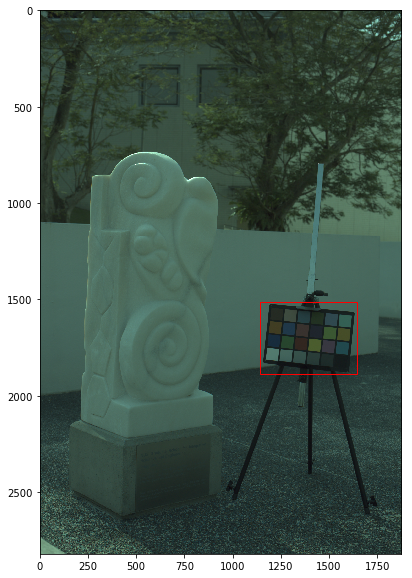

In [161]:
    
# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(10,10)
# Display the image
ax.imshow(norm_image)

temp_pt = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3],
                             linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(temp_pt)


    
plt.show()

## Tests on New Dataset

In [57]:
base_path = '../Data/new_photos/RAW/send/'
img_paths = os.listdir(base_path)

for n,path in enumerate(img_paths):

    temp_img = cv2.imread(base_path + path)
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_RGB2BGR)
    temp_img = cv2.resize(temp_img,(608,608), interpolation = cv2.INTER_AREA)
    plt.imsave('report_images/{}.png'.format(n+1), temp_img)
    

0
0_8.jpg
1
8D5U5537.TIF
2
8D5U5525.TIF
3
8D5U5583.TIF
4
8D5U5592.TIF
5
8D5U5560.TIF
6
0_0.jpg
7
0_11.jpg
8
0_1.jpg
9
0_3.jpg
10
step0_5.jpg
11
0_13.jpg
12
step0_4.jpg
13
0_2.jpg
14
step0_0.jpg
15
0_5.jpg
16
step0_3.jpg
17
0_4.jpg
